In [45]:
# import the usual libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import recall_score

## Q1 Cleaning Data (20 marks)

You will use the UCI Credit Approval Dataset where each record is a credit card application. All attribute names and values have been changed to meaningless symbols to maintain confidentiality. The dataset has been cleaned to remove missing attributes. The data is stored in a comma-separated file (csv) here. Each line describes an instance using 16 columns: the first 15 columns represent the attributes of the application, and the last column is the ground truth label for credit card approval. Note: The last column should not be treated as an attribute.

Required:

1. Clean the dataset and do any type conversions necessary
2. Ensure there are no null values, (imputing any if encountered)
3. Encode all categorical attributes see examples here
4. Scale the attributes of the dataset
5. Perform PCA to obtain attributes with which explains 95% of the variance in the data.

In [3]:
# lets open the dataset. There appears to be no columns in the csv so lets artificially create our own.
df = pd.read_csv("data/data.csv",names=["A"+str(x) for x in range(1,17,1)])
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [10]:
#lets check the data types
df.dtypes

A1      object
A2      object
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14     object
A15      int64
A16     object
dtype: object

In [12]:
#lets check for null values
df.isnull().any()

A1     False
A2     False
A3     False
A4     False
A5     False
A6     False
A7     False
A8     False
A9     False
A10    False
A11    False
A12    False
A13    False
A14    False
A15    False
A16    False
dtype: bool

Ok so not null values and a few object types. 

In [4]:
# lets encode all the worthy object type columns as categories
# operate on copy in case of mistakes
# rename last column to target since it gound level truth (class variable)
df2 = df.copy()
for col in df2.columns:
    if df2[col].dtype == 'object':
        df2[col] = df2[col].astype('category')
        df2[col] = df2[col].cat.codes
df2.rename(columns={'A16':'target'},inplace=True) 
df2.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,2,156,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,1,328,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,1,89,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,2,125,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,2,43,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0


In [5]:
#lets double check data types numeric
df2.dtypes

A1           int8
A2          int16
A3        float64
A4           int8
A5           int8
A6           int8
A7           int8
A8        float64
A9           int8
A10          int8
A11         int64
A12          int8
A13          int8
A14         int16
A15         int64
target       int8
dtype: object

In [30]:
# lets follow convention and make X the feature matrix and y the target
X = df2[df2.columns[:-1]]
y = df2['target']
# lets now scale the feature matrix
X = StandardScaler().fit_transform(X)
# lets fit the data to find the Principle components
pca = PCA(0.95)
X2 = pca.fit_transform(X)
# now lets compare the shape of the PCA matrix and the original and check the explained variances.
print(X2.shape,X.shape)
pca.explained_variance_ratio_

(690, 13) (690, 15)


array([0.17981879, 0.12653995, 0.09355925, 0.0830736 , 0.07163962,
       0.06833095, 0.06360784, 0.06015657, 0.05730793, 0.04926579,
       0.04267368, 0.04061716, 0.03541381])

so it looks like 13 principle components explain 95% or more of the data.

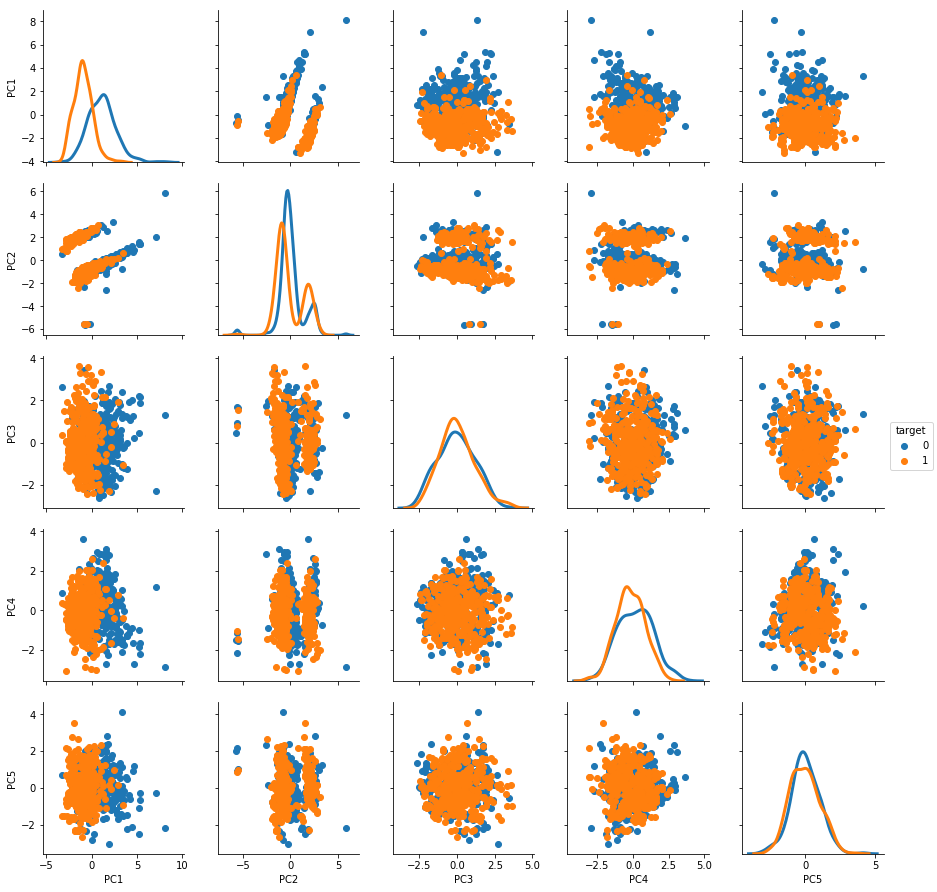

In [31]:
# lets have a look at a Pairplot to guage any potential relationships for the more important principle components
df3 = pd.DataFrame(data = X2, columns=["PC"+str(x +1) for x in range(X2.shape[1])])
df3 = pd.concat([df3,y],axis=1)
num_pc = 5 #number of principle components
g = sns.PairGrid(df3,x_vars=df3.columns[:num_pc],y_vars=df3.columns[:num_pc],hue='target')
g = g.map_upper(plt.scatter)
g = g.map_lower(plt.scatter)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
g = g.add_legend()

## Q2 Random Forest Classifier (50 marks)
Required:

Part 1: Using the RandomForest Classifier provided by the sklearn library

1. Initialize the classifier with default arbitrary paramenters
2. Train the classifier
3. Determine the recall score of the classifier

Part 2: Using the RandomizedSearchCV module provided by the sklearn library

1. Do parameter tuning to obtain the optimal parameters to initialize the RandomForest Classifier. The parameters to tune are as follow:

    1. n_estimators
    2. max_features
    3. max_depth
    4. min_samples_split
    5. min_sample_leaf
    6. bootstrap
    
2. Determine the recall score of the classifier

In [81]:
# lets make a new feature matrix and a new target matrix
X_2 = df2[df2.columns[:-1]]
y_2 = df2['target']
# no need to scale data for Random Forest Classfier as its entropy based.
# Lets fit data and compute recall score
random_forest = RandomForestClassifier()
random_forest.fit(X_2, y_2)
y_2pred = random_forest.predict(X_2)
print("Recall score is : {}".format(recall_score(y_2,y_2pred)))

Recall score is : 0.9947780678851175


In [83]:
# now lets scan some parameters to find the best combination
clf = RandomForestClassifier()
param_dist = {"n_estimators":[8,9,10,11,12,13,14,15],
              "max_depth": [2,3,4,5,None],
              "max_features": ['auto','log2',None],
              "min_samples_split": [2,3,4],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True, False]}
rand_search = RandomizedSearchCV(clf,param_distributions=param_dist)
rand_search.fit(X_2,y_2)
rand_search.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 12}

In [107]:
# Lets fit data and compute recall score for new classifier parameters
random_forest_new = RandomForestClassifier(bootstrap=False,max_depth=4,max_features='auto',min_samples_leaf=2,\
                                       min_samples_split=3,n_estimators=12)
random_forest_new.fit(X_2, y_2)
y_2pred_new = random_forest_new.predict(X_2)
print("Recall score is : {}".format(recall_score(y_2,y_2pred_new)))

Recall score is : 0.9530026109660574


## Q3 KNN Classifier (30 marks)
Required

Part 1: Using the KNN Classifier provided by the sklearn library

1. Initialize the classifier with default value for n_neighbors
2. Train the classifier
3. Determine the recall score of the classifier

Part 2: Using the cross_val_score module provided by the sklearn library

1. Perform 10 fold cross validation to obtain the optimal value to use for n_neighbor
2. Retrain the classifier
3. Determine the recall score of the classifier

In [109]:
# lets make a new feature matrix and a new target matrix
X_3 = df2[df2.columns[:-1]]
y_3 = df2['target']
# Lets scale data for KNN classifier as it benifits from standardized data.
X_3 = StandardScaler().fit_transform(X_3)
#initialise KNN with defaults
knn = KNeighborsClassifier()
# fitting the model
knn.fit(X_3, y_3)
# Score the model
y_3pred = knn.predict(X_3)
print("Recall score is : {}".format(recall_score(y_3,y_3pred)))

Recall score is : 0.9138381201044387


The best k value is : 7


Text(7,0.853706,'Best_K')

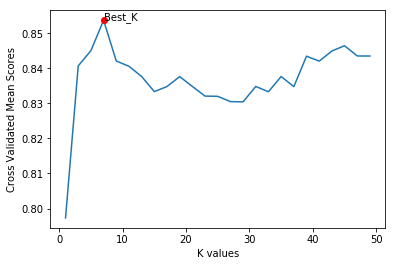

In [139]:
# creating odd list of K for KNN
neighbors = filter(lambda x: x % 2 != 0, list(range(1,50)))
# empty dict that will hold cv scores
cv_scores = {}
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_3, y_3, cv=10)
    cv_scores[k] = scores.mean()
#find the best k by looking for the highest score
best_k = max(cv_scores, key=lambda k: cv_scores[k])
print("The best k value is : {}".format(best_k))
# let look at a quick plot of k vs mean score
x_vals = []
y_vals = []
for item in cv_scores:
    x_vals.append(item)
    y_vals.append(cv_scores[item])
plt.plot(x,y)
plt.xlabel('K values')
plt.ylabel('Cross Validated Mean Scores')
plt.plot(best_k,y_vals[x_vals.index(best_k)], 'ro')
plt.annotate(xy=(best_k,y_vals[x_vals.index(best_k)]),s='Best_K')

In [138]:
# rerunning KNN with new k
#initialise KNN with defaults
knn_new = KNeighborsClassifier(n_neighbors=7)
# fitting the model
knn_new.fit(X_3, y_3)
# Score the model
y_3pred_new = knn_new.predict(X_3)
print("Recall score is : {}".format(recall_score(y_3,y_3pred_new)))

Recall score is : 0.9164490861618799
